# ITU YZV302(3)E Deep Learning Course Fall 2024

# HW3

# Q2: Part(a) Denoising-Autoencoder (35 pts)

In this question, you will explore and learn about autoencoders. Below, you are provided with a convolution-based autoencoder designed for the MNIST dataset. Running the code will train the autoencoder and then plot the loss curve against iterations.

The code will also show two pairs of input and target images, followed by a visualization of the hidden embedding space. The current experiment uses a hidden layer size of 2 for easier visualization, but this may be prevent learning complex problems. The embedding sizes can be increased to improve the quality of reconstructions but at the expense of visualizing the entire space. However, it is possible to plot dimensions individually to observe the a distributions. Learning compressed patterns will be easier using larger hidden embedding sizes.

In this this question you will convert the autoencoder into a Denoising Autoencoder. Here, you will create some controlled corruption in the input images, while the targets remain the original images. For example, you could delete a rectangular window from the image and ask the autoencoder to reconstruct the original. Alternatively, you could add Gaussian noise and ask the autoencoder to remove the noise.

The auto-encoder does not need to work perfectly. Play with the network, hyper-parameters as you wish, to create something which seems to work.

To get full points from this question
1. **[10 pts]** Implement the input image corruption code. Explain your corruption method. What factors influenced your choice?
2. **[5 pts]** Change the training loop to work as a denoising autoencoder.
3. **[5 pts]** Tune your architecture, training, corruption, and parameters briefly. Comment on what did you change and how it affected the results.
4. **[5 pts]** Comment on the results, plot at least TWO input-output pairs of of each digit (0-9). Describe your findings.
5. **[10 pts]** The current experiment runs only on the training set. It is possible that your autoencoder memorizes specific data points and corruptions, leading to poor generalization on unseen data. Does your network memorize or generalize denoising? Write down your answer in your analysis section and perform additional experiments to support your claims.

Note: You must implement the noise/corruption yourself.

For an example of what noisy/corrupted images look like, take a look at the 'noisy.png' image.

In [1]:
import torch
from torchvision import datasets
from torchvision import transforms
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
# plot the latent (hidden) space
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

In [2]:
# Transforms images to a PyTorch Tensor
tensor_transform = transforms.ToTensor()

# Download the MNIST Dataset
dataset = datasets.MNIST(root = "./data",
						train = True,
						download = True,
						transform = tensor_transform)

# DataLoader is used to load the dataset
# for training


loader = torch.utils.data.DataLoader(dataset = dataset,
									batch_size = 32,
									shuffle = True,pin_memory=True)



# Write your data corruption/noising function here. Call it from appropriate position in training.


In [3]:
def add_gaussian_noise(images, mean=0.2, std=0.2):
    #Adding Gaussian noise to the images
    noise = torch.randn_like(images) * std + mean
    noisy_images=images+noise
    #Clamping the pixel values to be between 0 and 1
    noisy_images = torch.clamp(noisy_images, 0.0, 1.0)
    return noisy_images


In [4]:
# auto encoder definition

# Creating a PyTorch class
# 28*28 ==> 9 ==> 28*28
### MODEL
##########################


class Reshape(nn.Module):
    def __init__(self, *args):
        super().__init__()
        self.shape = args

    def forward(self, x):
        return x.view(self.shape)


class Trim(nn.Module):
    def __init__(self, *args):
        super().__init__()

    def forward(self, x):
        return x[:, :, :28, :28]


class AutoEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        act = nn.LeakyReLU(0.01)
        self.encoder = nn.Sequential( #784
                nn.Conv2d(1, 32, stride=(1, 1), kernel_size=(3, 3), padding=1),
                act,
                nn.Conv2d(32, 64, stride=(2, 2), kernel_size=(3, 3), padding=1),
                act,
                nn.Conv2d(64, 64, stride=(2, 2), kernel_size=(3, 3), padding=1),
                act,
                nn.Conv2d(64, 64, stride=(1, 1), kernel_size=(3, 3), padding=1),
                nn.Flatten(),
                nn.Linear(3136, 2)
        )
        self.decoder = nn.Sequential(
                torch.nn.Linear(2, 3136),
                Reshape(-1, 64, 7, 7),
                nn.ConvTranspose2d(64, 64, stride=(1, 1), kernel_size=(3, 3), padding=1),
                act,
                nn.ConvTranspose2d(64, 64, stride=(2, 2), kernel_size=(3, 3), padding=1),
                act,
                nn.ConvTranspose2d(64, 32, stride=(2, 2), kernel_size=(3, 3), padding=0),
                act,
                nn.ConvTranspose2d(32, 1, stride=(1, 1), kernel_size=(2, 2), padding=0),  # kernel size (2,2) to replace trim.
                #Trim(),  # 1x29x29 -> 1x28x28
                nn.Sigmoid() # perhaps you can remove this and use linear or tanh instead and scale the output back.
                )

    def forward(self, x):
        h = self.encoder(x)
        x = self.decoder(h)
        return x,h

In [5]:
# Model Initialization
model = AutoEncoder()
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(DEVICE)


# Validation using MSE Loss function
loss_function = torch.nn.MSELoss()

# Using an Adam Optimizer with lr = 0.1
optimizer = torch.optim.Adam(model.parameters(),
							lr = 1e-4,
							weight_decay = 1e-5)
print(DEVICE)

cuda:0


In [6]:
epochs = 10
outputs = []
losses = []

for epoch in range(epochs):
    print("epoch:", epoch)
    model.train()
    for (image, _) in loader:
        image= image.to(DEVICE)


        # Apply noise to the input images
        noisy_image = torch.stack([add_gaussian_noise(img) for img in image])
        noisy_image = noisy_image.to(DEVICE)
        
        # Output of Autoencoder
        reconstructed, hid = model(noisy_image)

        # Calculating the loss function
        loss = loss_function(reconstructed, image)


        # The gradients are set to zero,
        # the gradient is computed and stored.
        # .step() performs parameter update
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Storing the losses in a list for plotting
        losses.append(loss)
        outputs.append((epochs, image, noisy_image, reconstructed))
    print('Epoch: %03d/%03d || Loss: %.4f'% (epoch+1, epochs, loss))

epoch: 0
Epoch: 001/010 || Loss: 0.0550
epoch: 1
Epoch: 002/010 || Loss: 0.0526
epoch: 2
Epoch: 003/010 || Loss: 0.0494
epoch: 3
Epoch: 004/010 || Loss: 0.0407
epoch: 4
Epoch: 005/010 || Loss: 0.0496
epoch: 5
Epoch: 006/010 || Loss: 0.0523
epoch: 6
Epoch: 007/010 || Loss: 0.0507
epoch: 7
Epoch: 008/010 || Loss: 0.0511
epoch: 8
Epoch: 009/010 || Loss: 0.0387
epoch: 9
Epoch: 010/010 || Loss: 0.0383


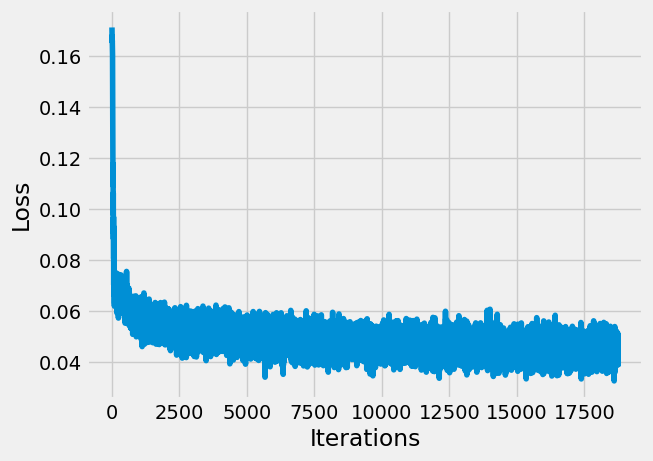

In [7]:
# plot the loss graph
# Defining the Plot Style
plt.style.use('fivethirtyeight')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.plot([t.detach().cpu() for t in losses])

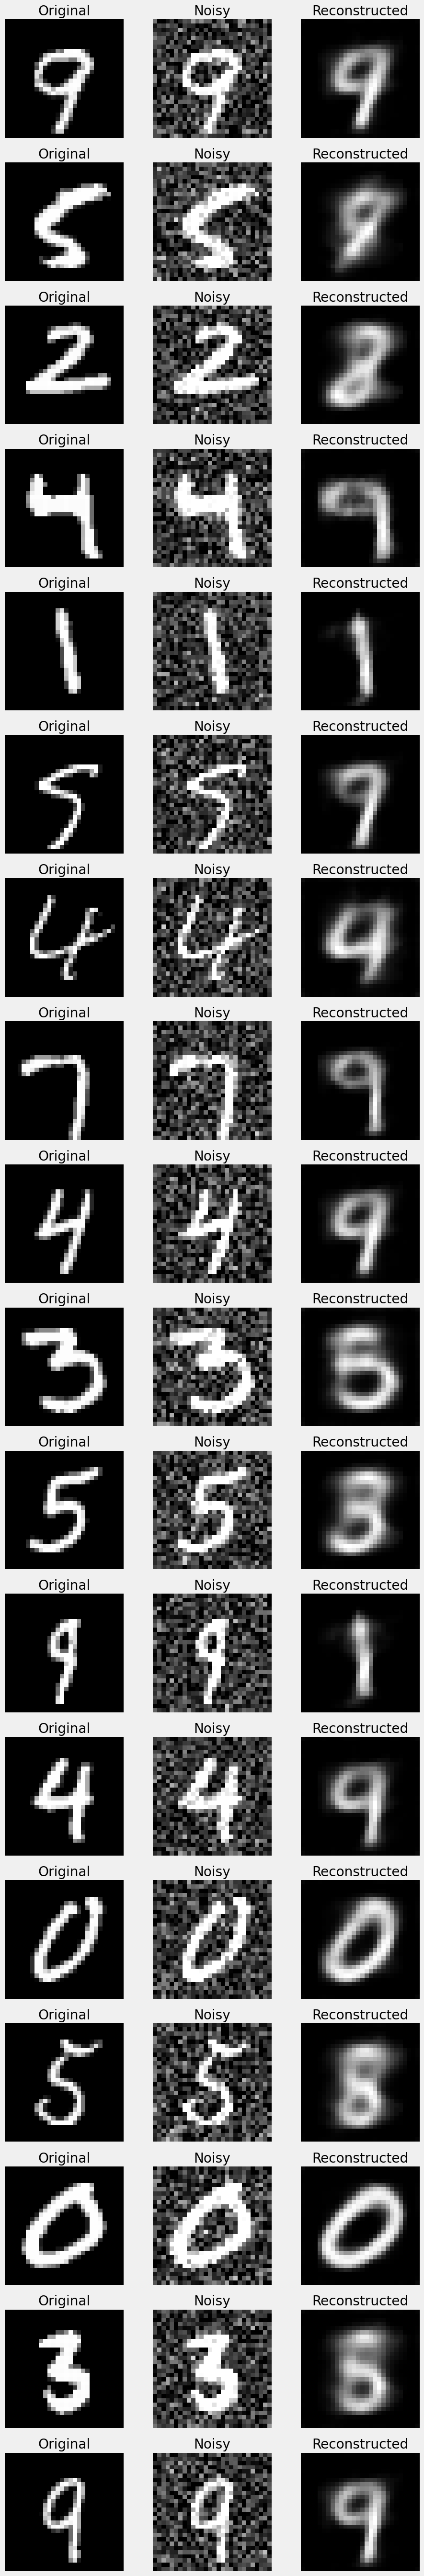

In [8]:
def plot_images(original, noisy, reconstructed, n=5):
    #Plot the original, noisy, and reconstructed images
    original = original.cpu().detach()
    noisy = noisy.cpu().detach()
    reconstructed = reconstructed.cpu().detach()
    
    fig, axes = plt.subplots(n, 3, figsize=(10, n * 3))
    for i in range(n):
        
        #Original Image
        axes[i, 0].imshow(original[i].squeeze(), cmap="gray")
        axes[i, 0].set_title("Original")
        axes[i, 0].axis("off")
        
        #Noisy Image
        axes[i, 1].imshow(noisy[i].squeeze(), cmap="gray")
        axes[i, 1].set_title("Noisy")
        axes[i, 1].axis("off")
        
        #Reconstructed Image
        axes[i, 2].imshow(reconstructed[i].squeeze(), cmap="gray")
        axes[i, 2].set_title("Reconstructed")
        axes[i, 2].axis("off")
    
    plt.tight_layout()
    plt.show()


#Extract a batch of images for visualization.
epoch, image_batch, noisy_batch, reconstructed_batch = outputs[-1]

#Plot the results.
plot_images(image_batch, noisy_batch, reconstructed_batch, n=18)

In [9]:
# plot the latent space if 2D
import numpy as np
def plot_latent_space_with_labels(num_classes, data_loader, model, device):
    d = {i:[] for i in range(num_classes)}

    model.eval()
    with torch.no_grad():
        for i, (features, targets) in enumerate(data_loader):

            features = features.to(device)
            targets = targets.to(device)

            embedding = model.encoder(features)

            for i in range(num_classes):
                if i in targets:
                    mask = targets == i
                    d[i].append(embedding[mask].to('cpu').numpy())

    colors = list(mcolors.TABLEAU_COLORS.items())
    for i in range(num_classes):
        d[i] = np.concatenate(d[i])
        plt.scatter(
            d[i][:, 0], d[i][:, 1],
            color=colors[i][1],
            label=f'{i}',
            alpha=0.5)

    plt.legend()

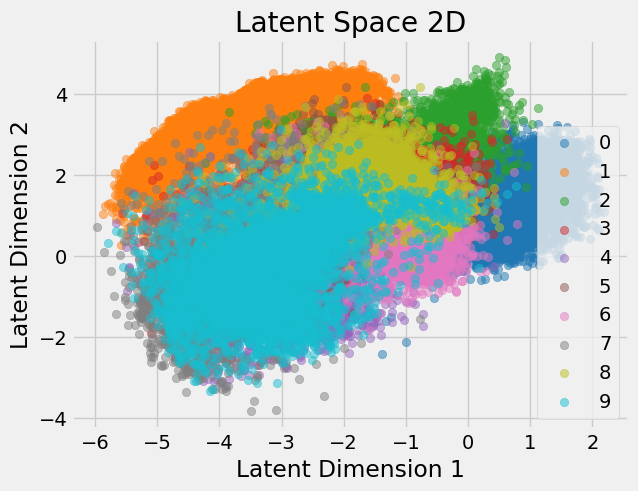

In [10]:
# call the above function to produce the graph below.
# Define number of classes (e.g., 10 for MNIST)
num_classes = 10

# Plot the latent space with labels
plot_latent_space_with_labels(num_classes, loader, model, DEVICE)

# Display the plot
plt.title("Latent Space 2D")
plt.xlabel("Latent Dimension 1")
plt.ylabel("Latent Dimension 2")
plt.legend()
plt.show()

# Add your analysis below

# As can be seen from  the below experiment, our model overfits to train set. When we test model with new line images it tries to produce number results. So it overfits, I tried to change parameters but the overfitting did not change. Model may be too complex for this problem. In some configurations model even overfitts to some numbers because of their dominant form. I used gaussian noise because it is more present in the problems. But others can be used to. As a result, model is memorizing specific moments and do not generalize.

In [11]:
def create_line_images(image_size=(28, 28)):

    horizontal_line = torch.zeros(image_size)
    vertical_line = torch.zeros(image_size)
    
    #Drawing-a-horizontal-line-in-the-center.
    horizontal_line[image_size[0] // 2, :] = 1.0
    
    #Drawing-a-vertical-line-in-the-center.
    vertical_line[:, image_size[1] // 2] = 1.0
    
    #Combining-into-a-batch.
    line_images = torch.stack([horizontal_line, vertical_line]).unsqueeze(1)  # (2, 1, H, W)
    return line_images

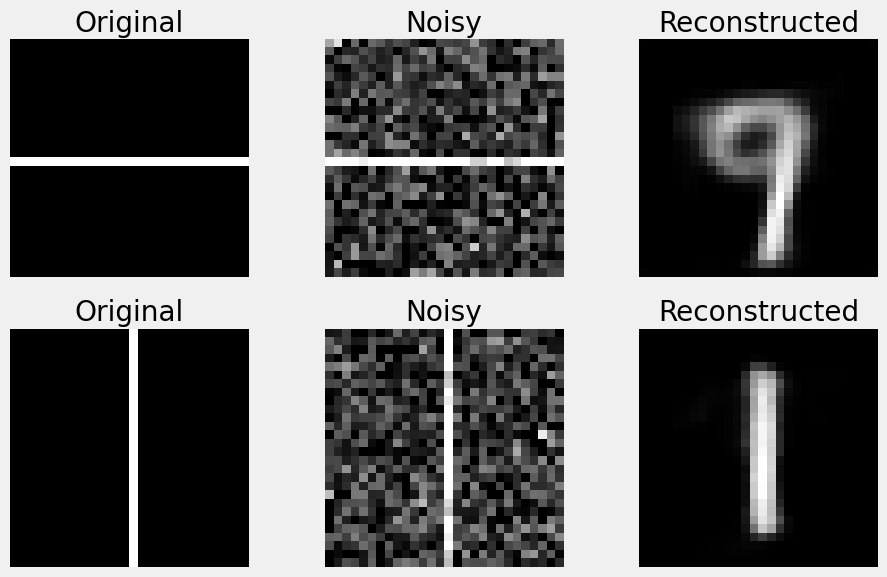

In [12]:
#Create-synthetic-line-images.
line_images=create_line_images()

#Add-noise-to-the-line-images.
noisy_line_images=torch.stack([add_gaussian_noise(img) for img in line_images])

#Pass-the-noisy-images-through-the-autoencoder.
line_images=line_images.to(DEVICE)
noisy_line_images=noisy_line_images.to(DEVICE)
reconstructed_line_images,_=model(noisy_line_images)

#Visualize-the-results.
plot_images(line_images,noisy_line_images,reconstructed_line_images,n=2)

# Q2-Part(b) - Variational AutoEncoders VAE   [25 pts]

In this section you are required to implement Variational Autoencoder. The general structure for VAE is given below. You can use it as a template.

Variational Autoencoder is a type of autoencoder that can be used as a generative model. It has a reparametrization trick in the bottleneck to allow gradient-based optimization.

There are couple of studies you can examine before implementing the model.

Auto-Encoding Variational Bayes: 
https://arxiv.org/abs/1312.6114

Understanding Variational Autoencoders (VAEs): https://towardsdatascience.com/understanding-variational-autoencoders-vaes-f70510919f73

### Load the SVHN data

In [13]:
import torch
from torch import nn, optim
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F

batch_size = 64 

train_data = datasets.SVHN(root = "data", split = 'train', transform = transforms.ToTensor(), download = True)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True) 

test_data = datasets.SVHN(root = "data", split = 'test', transform = transforms.ToTensor(), download = True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True) 

### Implement the VAE Architecture of your Design [12 pts]

Use Conv2d, ConvTranspose2d, Linear, and Activation Layers to design a Variational Autoencoder Architecture

In [14]:
class ResBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ResBlock, self).__init__()
        #Defining convolutional block
        self.conv_block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.2),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels)
        )
        #Defining skip connection
        self.skip = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1)
            if in_channels != out_channels else nn.Identity(),
            nn.BatchNorm2d(out_channels)
            if in_channels != out_channels else nn.Identity()
        )
        #Defining activation function
        self.activation = nn.LeakyReLU(0.2)

    def forward(self, x):
        #Adding skip connection to convolutional block
        return self.activation(self.conv_block(x) + self.skip(x))

class ResBlockTranspose(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ResBlockTranspose, self).__init__()
        #Defining convolutional block
        self.conv_block = nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.2),
            nn.ConvTranspose2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels)
        )
        #Defining skip connection
        self.skip = nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size=1)
            if in_channels != out_channels else nn.Identity(),
            nn.BatchNorm2d(out_channels)
            if in_channels != out_channels else nn.Identity()
        )
        #Defining activation function
        self.activation = nn.LeakyReLU(0.2)

    def forward(self, x):
        #Adding skip connection to convolutional block
        return self.activation(self.conv_block(x) + self.skip(x))

class ImprovedVAE(nn.Module):
    def __init__(self, latent_dim=128):
        super(ImprovedVAE, self).__init__()
        
        #Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1),  #32x32->16x16
            nn.LeakyReLU(0.2),
            ResBlock(64, 64),
            
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),  #16x16->8x8
            nn.LeakyReLU(0.2),
            ResBlock(128, 128),
            
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),  #8x8->4x4
            nn.LeakyReLU(0.2),
            ResBlock(256, 256),
            
            nn.Flatten(),
            nn.Dropout(0.2)
        )
        
        #Latent space
        self.fc_mu = nn.Sequential(
            nn.Linear(256 * 4 * 4, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, latent_dim)
        )
        
        self.fc_logvar = nn.Sequential(
            nn.Linear(256 * 4 * 4, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, latent_dim)
        )
        
        #Decoder
        self.decoder_input = nn.Sequential(
            nn.Linear(latent_dim, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 256 * 4 * 4),
            nn.LeakyReLU(0.2)
        )
        
        self.decoder = nn.Sequential(
            Reshape(-1, 256, 4, 4),
            ResBlockTranspose(256, 256),
            
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),  #4x4->8x8
            nn.LeakyReLU(0.2),
            ResBlockTranspose(128, 128),
            
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),  #8x8->16x16
            nn.LeakyReLU(0.2),
            ResBlockTranspose(64, 64),
            
            nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1),  #16x16->32x32
            nn.Sigmoid()
        )

    def encode(self, x):
        #Encoding input.
        encoded=self.encoder(x)
        #Returning mean and log variance.
        return self.fc_mu(encoded), self.fc_logvar(encoded)

    def reparameterize(self, mu, logvar):
        #Reparameterizing
        if self.training:
            #Calculating standard deviation
            std = torch.exp(0.5 * logvar)
            #Generating random noise
            eps = torch.randn_like(std)
            #Returning reparameterized value
            return mu + eps * std
        #Returning mean if not training
        return mu

    def decode(self, z):
        #Decoding latent vector
        return self.decoder(self.decoder_input(z))

    def forward(self, x):
        #Forward pass
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

    def loss_function(self, recon_x, x, mu, logvar, kld_weight=0.01):
        #Calculating loss
        batch_size = x.size(0)
        
        #Reconstruction loss(MSE)-normalized by batch size
        recon_loss = F.mse_loss(recon_x, x, reduction='sum') / batch_size
        
        #KL divergence loss-normalized by batch size and dimensions
        kld_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()) / batch_size
        
        #Perceptual loss(L1)-normalized by batch size
        perceptual_loss = F.l1_loss(recon_x, x, reduction='sum') / batch_size
        
        #Combining losses with proper weighting
        #Using smaller weights for KLD and perceptual loss to balance the terms
        total_loss = recon_loss + kld_weight * kld_loss + 0.01 * perceptual_loss
        
        return total_loss

### Initialization of the Optimizer: You can change the Parameters according to your needs

In [15]:
vae = ImprovedVAE(latent_dim=128)                                                   #Initializing-VAE-model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")               #Setting-device
optimizer = torch.optim.Adam(vae.parameters(), lr=0.001)                            #Creating-optimizer
vae = vae.to(device)                                                                #Moving-model-to-device


### Implement training loop [1 pt]

In [16]:
#Training Loop
def train_vae(model, train_loader, optimizer, device, epochs=10):
    model.to(device)
    model.train()
    train_losses = []

    for epoch in range(epochs):
        total_loss = 0
        for batch_idx, (data, _) in enumerate(train_loader):
            data = data.to(device)
            optimizer.zero_grad()

            #Forward pass
            recon_data, mu, logvar = model(data)

            #Computing loss
            loss = model.loss_function(recon_data, data, mu, logvar)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        #Calculating average loss
        average_loss = total_loss / len(train_loader.dataset)
        train_losses.append(average_loss)
        print(f"Epoch {epoch + 1}/{epochs}, Loss: {average_loss:.4f}")

    return train_losses

In [17]:
train_losses = train_vae(vae, train_loader, optimizer, device, epochs=10)

Epoch 1/10, Loss: 316.1035
Epoch 2/10, Loss: 0.4739
Epoch 3/10, Loss: 0.4133
Epoch 4/10, Loss: 0.3612
Epoch 5/10, Loss: 0.3245
Epoch 6/10, Loss: 0.2956
Epoch 7/10, Loss: 0.2690
Epoch 8/10, Loss: 0.2503
Epoch 9/10, Loss: 0.2323
Epoch 10/10, Loss: 0.2182


### Report the training loss curves for VAE. [1 pt]

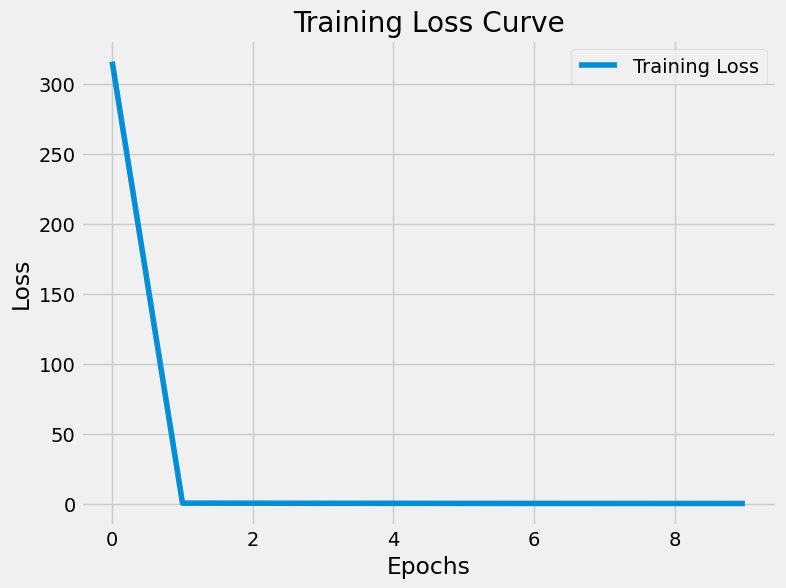

In [18]:
# Plot Training Curves
def plot_training_curves(train_losses):
    plt.figure(figsize=(8, 6))
    plt.plot(train_losses, label='Training Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training Loss Curve')
    plt.legend()
    plt.show()

plot_training_curves(train_losses)

### Show test results (generated images) for VAE. Also briefly discuss the results. [4 pts]

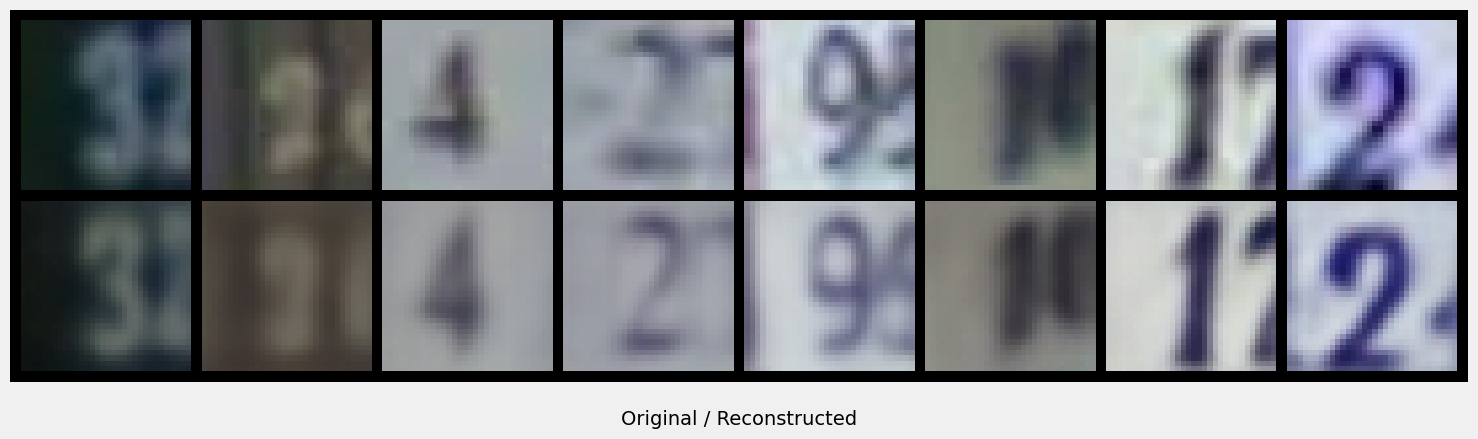

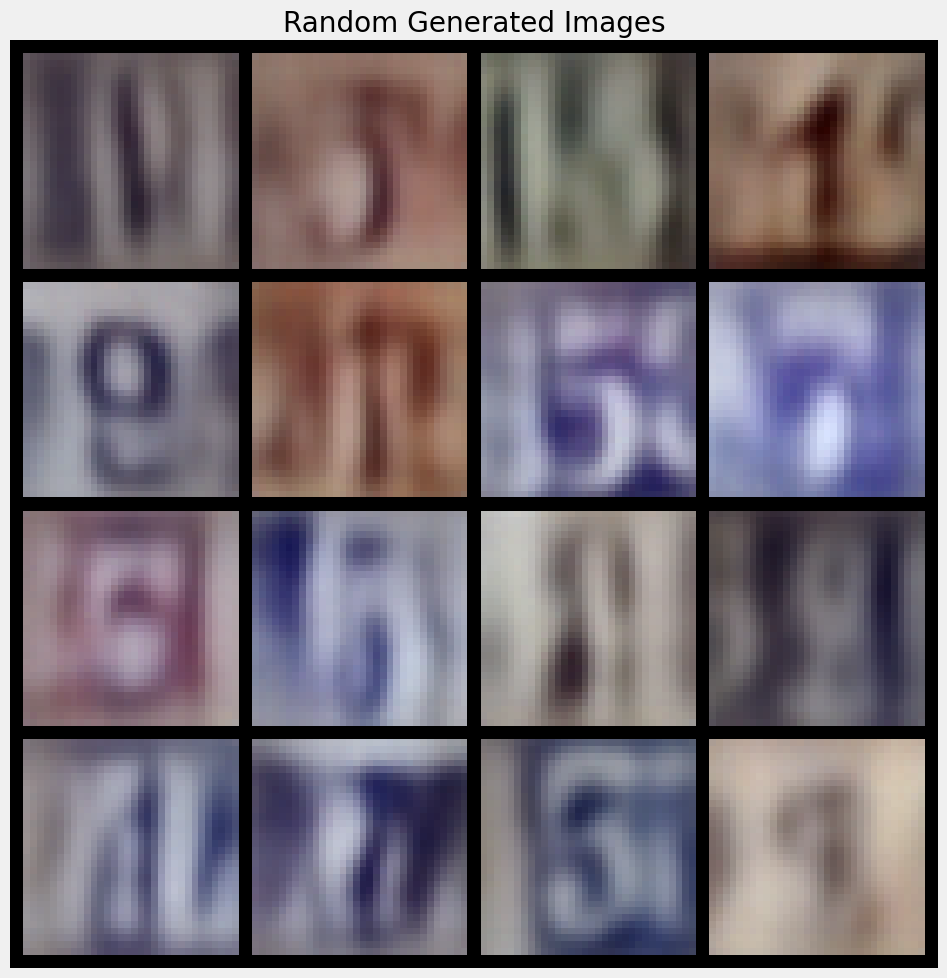

In [19]:
from torchvision.utils import make_grid
import numpy as np

def show_images(model, data_loader, device, num_images=8):

    #Set model to eval mode.
    model.eval()
    
    #Get a batch of images.
    with torch.no_grad():
        images, _ = next(iter(data_loader))
        images = images[:num_images].to(device)
        
        #Getting reconstructions.
        reconstructions, mu, logvar = model(images)
        
        #Converting to grid.
        comparison = torch.cat([images, reconstructions])
        comparison = make_grid(comparison, nrow=num_images, normalize=True, padding=2)
        
        #Converting to numpy for plotting.
        comparison = comparison.cpu().numpy()
        
        #Plotting.
        plt.figure(figsize=(15, 5))
        plt.subplot(1, 1, 1)
        plt.imshow(np.transpose(comparison, (1, 2, 0)))
        plt.axis('off')
        
        #Add labels.
        plt.text(0.5, -0.1, 'Original / Reconstructed', 
                horizontalalignment='center', verticalalignment='center', 
                transform=plt.gca().transAxes)
        
        plt.tight_layout()
        plt.show()

def interpolate_latent_space(model, data_loader, device, num_interpolation=8):

    #Set model to eval mode.
    model.eval()
    
    with torch.no_grad():
        #Get two random points in latent space.
        z1 = torch.randn(1, model.fc_mu[-1].out_features).to(device)
        z2 = torch.randn(1, model.fc_mu[-1].out_features).to(device)
        
        #Create interpolation points.
        alphas = np.linspace(0, 1, num_interpolation)
        z_interpolated = torch.cat([torch.lerp(z1, z2, alpha) for alpha in alphas])
        
        #Generate images.
        interpolated_images = model.decode(z_interpolated)
        
        #Convert to grid.
        grid = make_grid(interpolated_images, nrow=num_interpolation, normalize=True, padding=2)
        
        #Plotting
        plt.figure(figsize=(15, 3))
        plt.imshow(np.transpose(grid.cpu().numpy(), (1, 2, 0)))
        plt.axis('off')
        plt.title('Interpolation in Latent Space')
        plt.tight_layout()
        plt.show()

def plot_random_generations(model, device, num_images=16):

    #Set model to eval mode.
    model.eval()
    
    with torch.no_grad():
        
        #Generatin random latent vectors.
        z = torch.randn(num_images, model.fc_mu[-1].out_features).to(device)
        
        #Generating images.
        generated = model.decode(z)
        
        #Creating grid.
        grid = make_grid(generated, nrow=int(np.sqrt(num_images)), normalize=True, padding=2)
        
        #Plotting
        plt.figure(figsize=(10, 10))
        plt.imshow(np.transpose(grid.cpu().numpy(), (1, 2, 0)))
        plt.axis('off')
        plt.title('Random Generated Images')
        plt.tight_layout()
        plt.show()


vae = vae.to(device)
vae.eval()

# original, reconstructed images
show_images(vae, test_loader, device)

# Show random generations
plot_random_generations(vae, device)

### Randomly generate a sample then traverse in its latent space dimensions (add small numbers to only one dimension) see how it affects generated images. [7 pts]

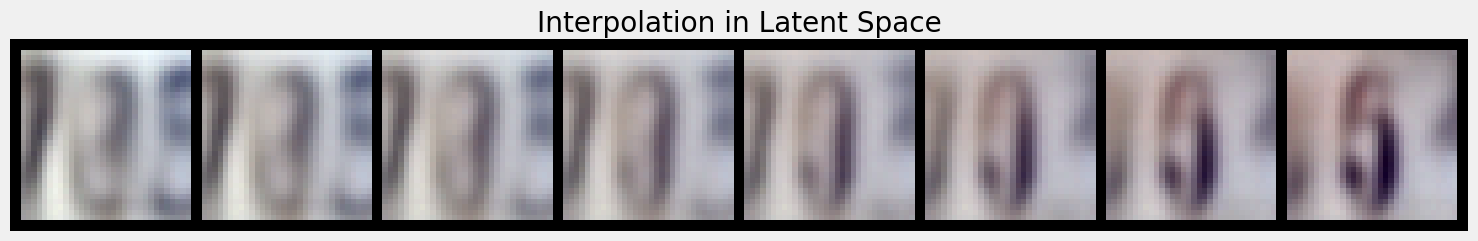

In [20]:
# Effect of latent space interpolation
interpolate_latent_space(vae, test_loader, device)

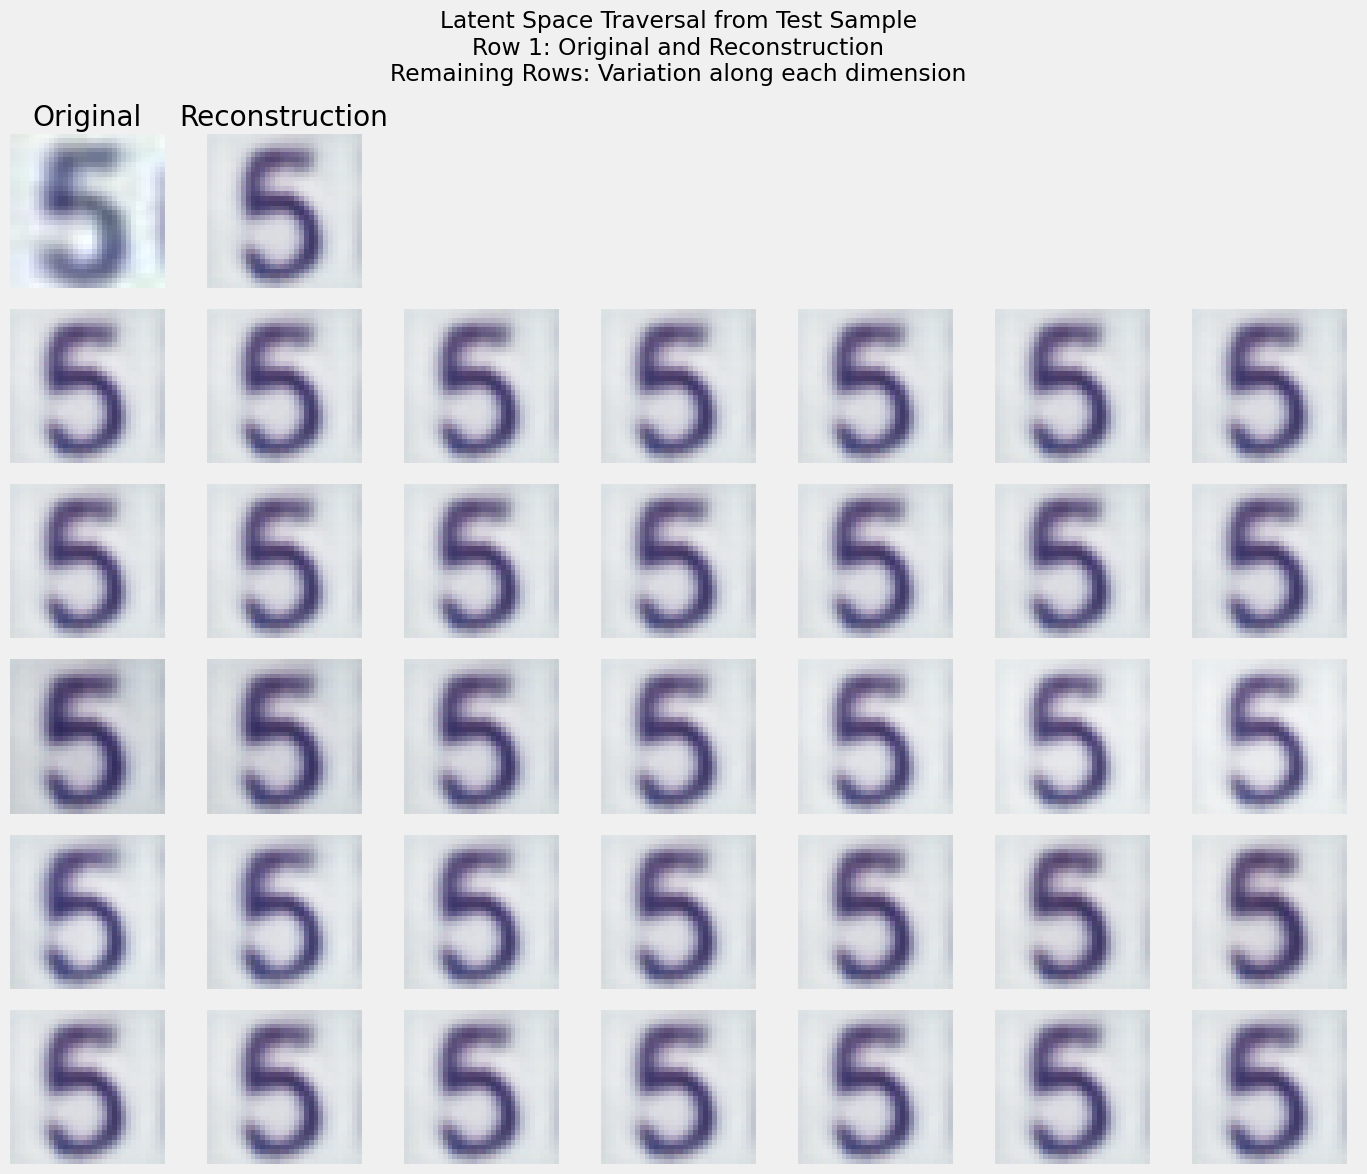

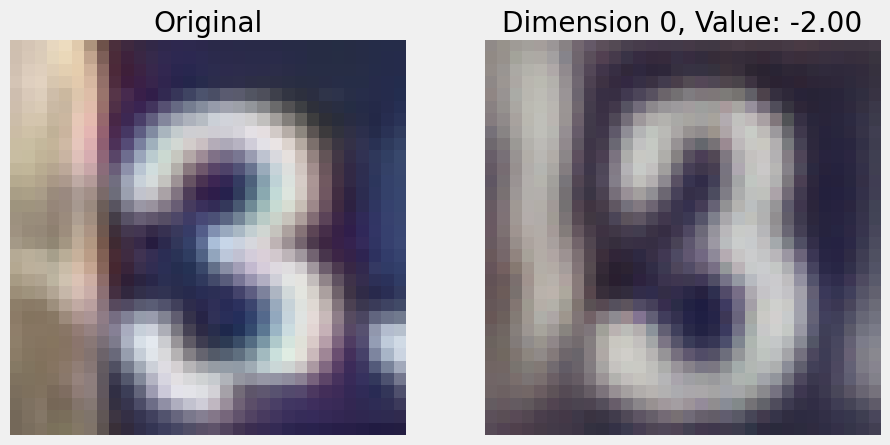

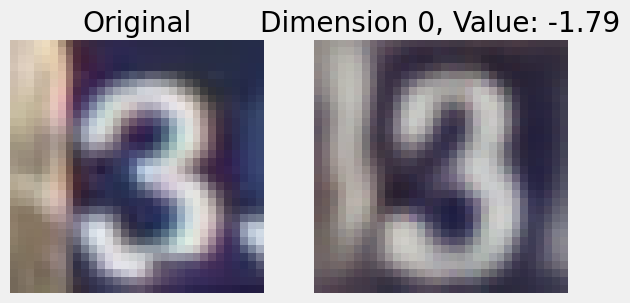

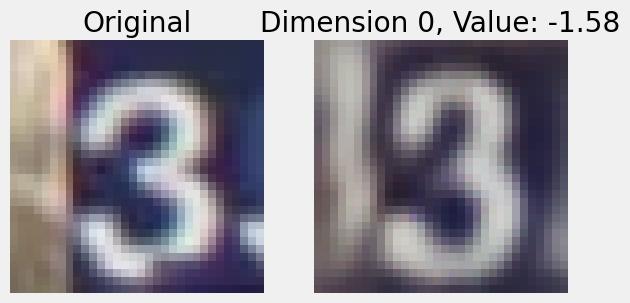

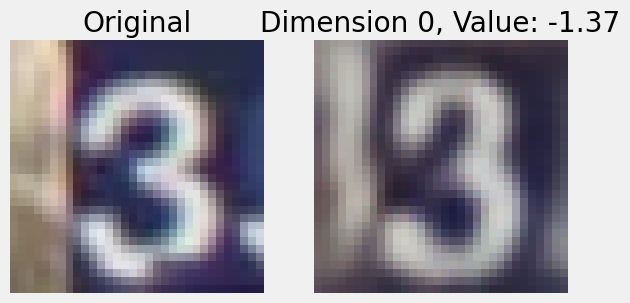

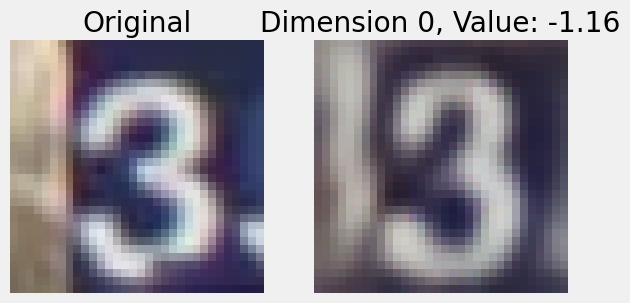

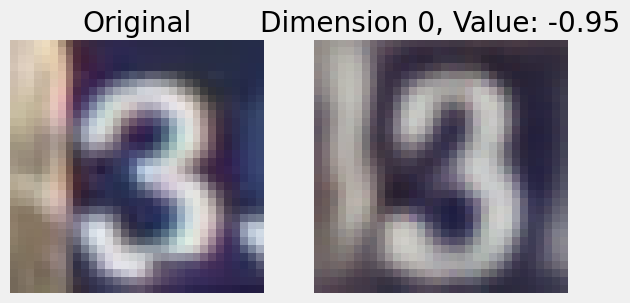

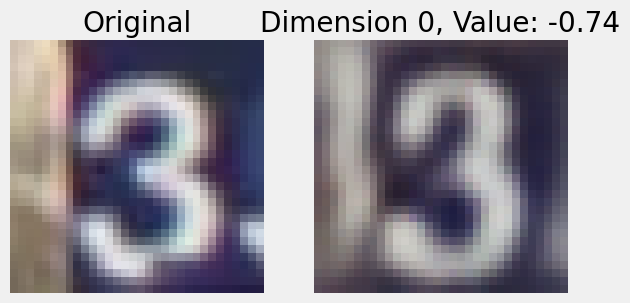

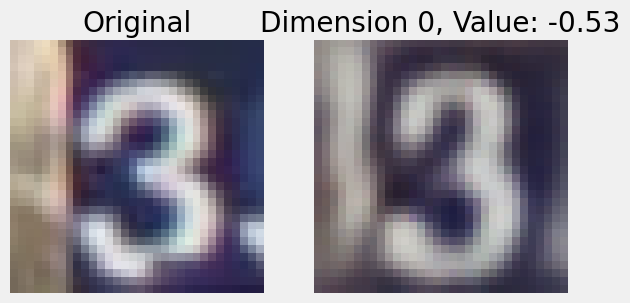

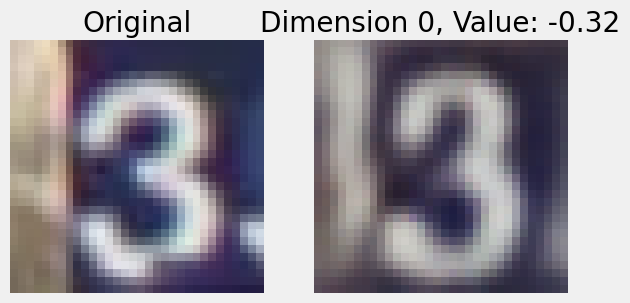

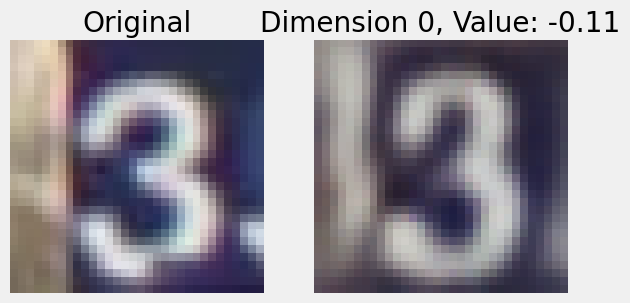

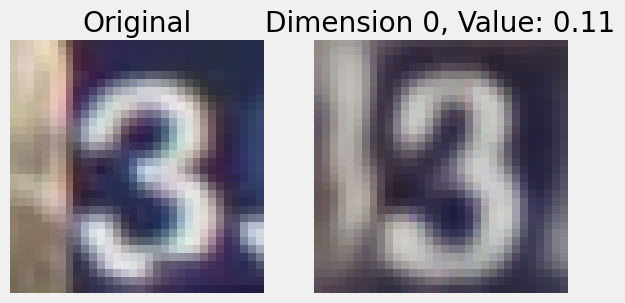

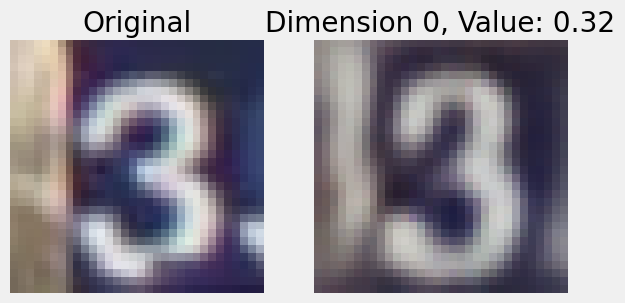

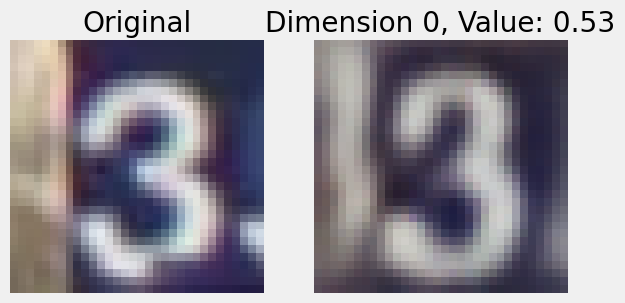

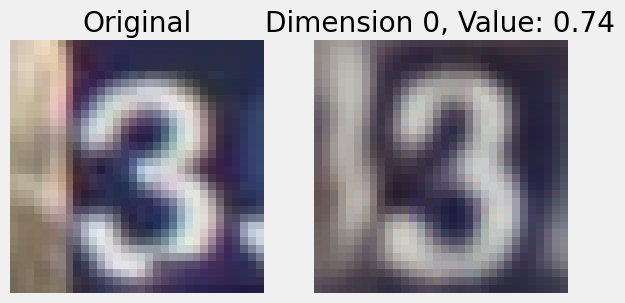

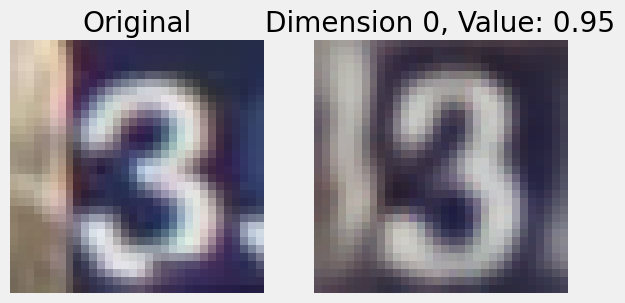

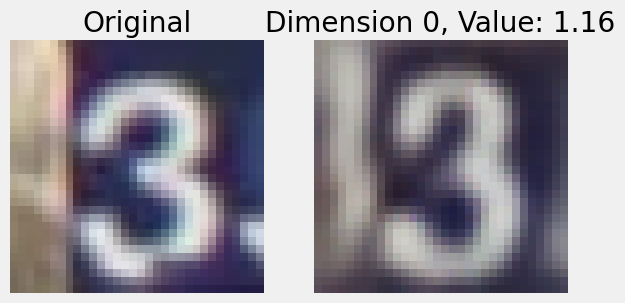

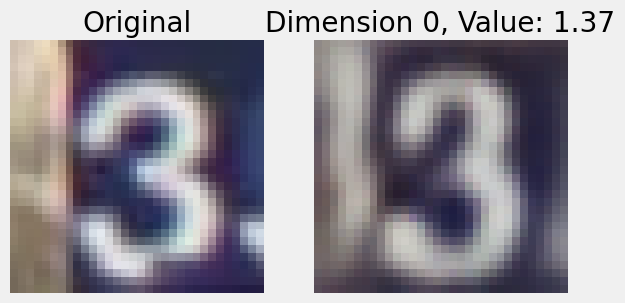

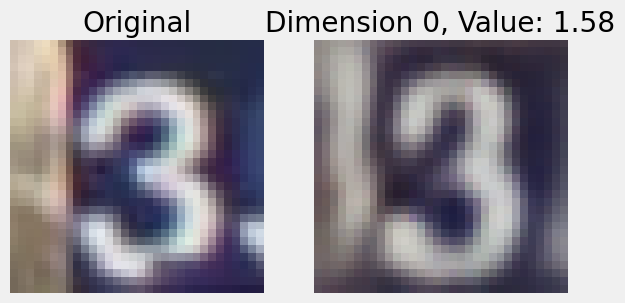

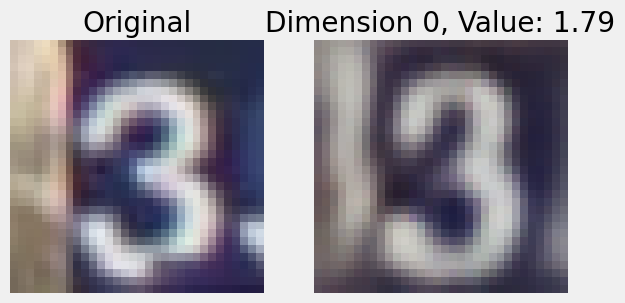

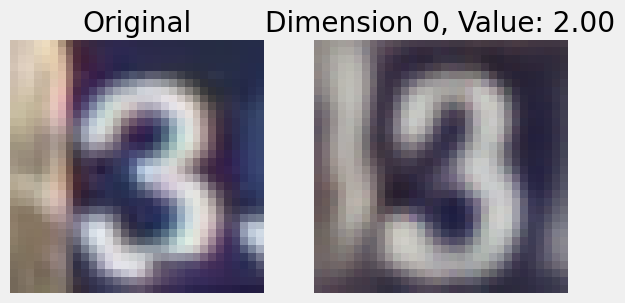

In [21]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from torchvision.utils import make_grid

def traverse_latent_space_from_sample(model, test_loader, device, num_dims=5, num_steps=7, scale=2.0):
    
    #Set model to eval mode.
    model.eval()
    
    with torch.no_grad():
        
        # sample from test set
        x, _ = next(iter(test_loader))
        x = x[0].unsqueeze(0).to(device)  # Take first image and add batch dimension
        
        # Encoding the test sample to get its latent representation
        mu, logvar = model.encode(x)
        z_base = model.reparameterize(mu, logvar)
        
        # Create figure with additional row for original and reconstruction
        fig, axes = plt.subplots(num_dims + 1, num_steps, 
                                figsize=(num_steps*2, (num_dims+1)*2))
        
        #Plotting original image and its reconstruction.
        axes[0, 0].imshow(x[0].cpu().numpy().transpose(1, 2, 0))
        axes[0, 0].set_title('Original')
        axes[0, 0].axis('off')
        
        recon = model.decode(z_base)
        axes[0, 1].imshow(recon[0].cpu().numpy().transpose(1, 2, 0))
        axes[0, 1].set_title('Reconstruction')
        axes[0, 1].axis('off')
        
        #Clear row for remaining columns
        for j in range(2, num_steps):
            axes[0, j].axis('off')
        
        #Traversal steps
        steps = np.linspace(-scale, scale, num_steps)
        
        # Traversing each dimension
        for dim in range(num_dims):
            for step_idx, step in enumerate(steps):
                
                z = z_base.clone()
                
                # Modifying only the current dimension
                z[0, dim] += step
                
                # Generating image
                generated = model.decode(z)
                
                # Convert to numpy and reshape for plotting
                img = generated[0].cpu().numpy().transpose(1, 2, 0)
                
                # Plotting.
                axes[dim + 1, step_idx].imshow(img)
                axes[dim + 1, step_idx].axis('off')
                
                if step_idx == 0:
                    axes[dim + 1, 0].set_ylabel(f'Dim {dim}')
                
                # Add value labels for last row
                if dim == num_dims - 1:
                    axes[dim + 1, step_idx].set_xlabel(f'{step:.1f}')
        
        plt.suptitle('Latent Space Traversal from Test Sample\nRow 1: Original and Reconstruction\nRemaining Rows: Variation along each dimension')
        plt.tight_layout()
        plt.show()

def animated_traversal_from_sample(model, test_loader, device, dim_to_traverse=0, num_steps=20, scale=2.0):
    
    #Set model to eval mode.
    model.eval()
    
    with torch.no_grad():
        #  sample from test set
        x, _ = next(iter(test_loader))
        x = x[0].unsqueeze(0).to(device)  # Take first image and add batch dimension
        
        # Encoding the test sample
        mu, logvar = model.encode(x)
        z_base = model.reparameterize(mu, logvar)
        
        # Creating steps for smooth traversal
        steps = np.linspace(-scale, scale, num_steps)
        
        plt.figure(figsize=(10, 5))
        
        # Plotting original and reconstructed images
        plt.subplot(1, 2, 1)
        plt.imshow(x[0].cpu().numpy().transpose(1, 2, 0))
        plt.title('Original')
        plt.axis('off')
        
        # Creating subplot for traversal
        plt.subplot(1, 2, 2)
        
        for step in steps:
            
            z = z_base.clone()
            
            # Modifying the chosen dimension
            z[0, dim_to_traverse] += step
            
            # Generating image
            generated = model.decode(z)
            
            # Converting to numpy
            img = generated[0].cpu().numpy().transpose(1, 2, 0)
            
            # Plotting
            plt.clf()
            plt.subplot(1, 2, 1)
            plt.imshow(x[0].cpu().numpy().transpose(1, 2, 0))
            plt.title('Original')
            plt.axis('off')
            
            plt.subplot(1, 2, 2)
            plt.imshow(img)
            plt.title(f'Dimension {dim_to_traverse}, Value: {step:.2f}')
            plt.axis('off')
            
            plt.pause(0.1)
        
        plt.show()

vae = vae.to(device)
vae.eval()

# Show static traversal of multiple dimensions
traverse_latent_space_from_sample(vae, test_loader, device, 
                                num_dims=5, num_steps=7, scale=2.0)

# Show animated traversal of a single dimension
animated_traversal_from_sample(vae, test_loader, device,
                             dim_to_traverse=0, num_steps=20, scale=2.0)

#### After you have completed the training, save your model and share a google drive link for the model

In [22]:
# Quick save current state
torch.save(vae.state_dict(), 'vae_model.pth')


In [23]:
"   https://drive.google.com/file/d/1QowgsGBZfvYgNLOsBCotxsJGWX6NYpCr/view?usp=drive_link   " 

'   https://drive.google.com/file/d/1QowgsGBZfvYgNLOsBCotxsJGWX6NYpCr/view?usp=drive_link   '